# K-medoids

**Update 11/Feb/2020**
Apply kmedoids and tsne on the whole design space (data/idx_seq.pickle: 4^6 + 61 bps). 
The distance matrix based on kernel can be generated from saved_normalised_kernel.pickle.   
Then visualse data for selected subset only.

**Update 30/Oct/2020**  
Visualise the sequences in round 0 and round 1, to see whether sequences in round 1 is similar to round 0 or not.
The similarity should be measured exactly the same as how we generate round 1's recommnedations.
Two ways to show that:  
- clustering (k-medoids) on round 0 and round 1 sequences, then show the clusterings using TSNE (2d). 
- sort sequences by similarity (hierichycial clustering). Show two plots: one is heatmap with dendrograms (for feature similarity), see some examples [here](https://datavizpyr.com/hierarchically-clustered-heatmap-with-seaborn-in-python/) and [here](https://stackoverflow.com/questions/2455761/reordering-matrix-elements-to-reflect-column-and-row-clustering-in-naiive-python);
the other one is a 3D heatmap for labels, see [here]().  

**End Update**

For exploration, we should spread the choices as much as possible. Since we do not want to waste the engergy for searching the same region which may give bad results. The UCB algorithm balance the exploration and exploitation by balancing weights on predicted mean and predicted variance. To check whether UCB algorithm gives a reasonable coverage of the unknown spacing and known spacing, we run a clustering algorithm on the whole exploration space. We expect to cover several sequences in each clustering at the first a few rounds, then focusing more on sequences on the clustering gives a relatively high performance. 


## Pipeline

- Embedding
    - kmers ([3], [2,3,4,5,6])
    - onehot
- PCA
    - number of component (select by singular_values_)
- Clustering (Kmeans++)
    - number of clustering (Elbow method to select good number of clusterings)
- TSNE (to 2 dims) for visualisation
   
## Evaluation

- We show the average value and variance of label for the sequences in each clustering

Ideas:

A possible idea is to combine the clustering and successive rejects, where rejects happens in terms of clusters rather than single data points. This solves the problem that the searching space (number of arms) are too large. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.cluster import KMeans
from nltk.metrics import distance 
# import Pycluster as PC
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import math

from codes.kernels_for_GPK import *
from codes.embedding import Embedding

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids

## Known seq

In [2]:
norm_method = 'mean'
log_flag = 'True'

Path_raw = '../../data/Results_Microplate_partialTrue_normFalse_formatSeq.csv'
Path_normalised = '../../data/Results_Microplate_partialTrue_normTrue_' + norm_method+ '_roundRep_formatSeq_log' + log_flag + '.csv'

Path = Path_raw

df = pd.read_csv(Path)
# df['Group Code'] = df.Group.astype('category').cat.codes
known_data = df[['RBS', 'RBS6', 'Group', 'Pred Mean', 'AVERAGE', 'Plate']]
known_seq = np.asarray(df['RBS'])

In [3]:
known_data

,RBS,RBS6,Group,Pred Mean,AVERAGE,Plate
0,TTTAAGAAGGAGATATACAT,AGGAGA,Consensus,NaN,65.552569,First_Plate
1,CTTAAGAAGGAGATATACAT,AGGAGA,BPS-NC,NaN,51.337763,First_Plate
2,GTTAAGAAGGAGATATACAT,AGGAGA,BPS-NC,NaN,33.432289,First_Plate
3,ATTAAGAAGGAGATATACAT,AGGAGA,BPS-NC,NaN,47.786526,First_Plate
4,TCTAAGAAGGAGATATACAT,AGGAGA,BPS-NC,NaN,50.155661,First_Plate
...,...,...,...,...,...,...
353,TTTAAGAGGTAGGTATACAT,GGTAGG,Bandit-2,NaN,51.531335,Fourth_Plate
354,TTTAAGACCTTCTTATACAT,CCTTCT,Bandit-2,NaN,35.121195,Fourth_Plate
355,TTTAAGAAGGAGATATACAT,AGGAGA,Consensus,NaN,72.483149,Fourth_Plate
356,TTTAAGAAGGAGATATACAT,AGGAGA,Consensus,NaN,77.321597,Fourth_Plate


In [4]:
known_seq.shape

(358,)

## Setting

In [5]:
random_state = 0
n_dim = 2 # dimension reduction 
scores = {}

n_clusters = 16 # to be changed

In [6]:
wds_kernel = WD_Shift_Kernel(l = 6, s=1)

wd_shift_distance = wds_kernel.distance(wds_kernel.kernel_all_normalised)
distance_matrix = wd_shift_distance
distance_matrix_name = 'wd_shift_distance'

# spec_distance = Spectrum_Kernel(l_list = [1,2,3,4,5,6]).distance(known_seq)
# wd_distance = WeightedDegree_Kernel(l_list = [6]).distance(known_seq)
# mismatch_distance = Mismatch_Kernel(l_list= [6]).distance(known_seq)

# distance_matrix = [spec_distance, wd_distance, wd_shift_distance, mismatch_distance]
# distance_matrix_name = ['spec_distance', 'wd_distance', 'wd_shift_distance', 'mismatch_distance']

wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...


In [7]:
wds_kernel.kernel_all_normalised.shape

(4138, 4138)

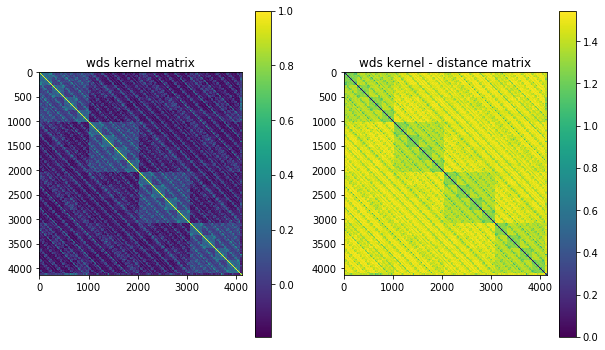

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

im0 = axes[0].imshow(wds_kernel.kernel_all_normalised)
fig.colorbar(im0, ax = axes[0])
axes[0].set_title('wds kernel matrix')

im1 = axes[1].imshow(wd_shift_distance)
fig.colorbar(im1, ax = axes[1])
axes[1].set_title('wds kernel - distance matrix')

plt.show()

In [9]:
def show_tsne_with_clustering(tsne_X, n_clusters, y_km):
    plt.figure(figsize = (15,15))
    for i in range(n_clusters):
        plt.scatter(
            tsne_X[y_km == i, 0], tsne_X[y_km == i, 1],
            s=50, 
            label=str(i)
            )
    plt.legend()
    plt.show()

## K-medoids and TSNE

In [10]:
from pathlib import Path

file_name = 'Clustering/results/round01_tsne_kmedoid_' + distance_matrix_name +  '_' + str(n_clusters) + '_clusters.npz'
file_path = Path(file_name)
print(file_path)

if file_path.exists():
    print('File exists. Reading file.')
    # with np.load(file_name, allow_pickle = True) as file:
    #     data = file
    data = np.load(file_path, allow_pickle=True)

else:
    distance = distance_matrix

    # clustering
    kmedoids = KMedoids(n_clusters=n_clusters, metric = 'precomputed', init='k-medoids++', random_state=random_state).fit(distance)
    y_km_spec = kmedoids.labels_
    
    # dim reduction
    tsne = TSNE(n_components = n_dim, metric = 'precomputed')
    tsne_X_spec = tsne.fit_transform(distance)
    # show_tsne_with_clustering(tsne_X_spec, n_clusters, y_km_spec)
    
    # save file
    np.savez(file_name, coord = tsne_X_spec, text = known_data, ykm = y_km_spec, known_seq = [], ucb_rec = [])
    print('result saved')

Clustering/results/round01_tsne_kmedoid_wd_shift_distance_16_clusters.npz
File exists. Reading file.


In [11]:
# read saved data and plot

embed = data['coord']
# y = data['label']
text = data['text']
y_km = data['ykm']
known_seq = data['known_seq']
ucb_rec = data['ucb_rec']

In [12]:
def sigmoid(z_list):
    func_z_list = []
    for z in z_list:
        func_z_list.append(10.0/(1 + np.exp(-z)))
    return func_z_list

def normalise_minmax(z_list):
    min_value = np.min(z_list)
    max_value = np.max(z_list)
    func_z_list = []
    for z in z_list:
        func_z_list.append(5 * (z-min_value)/(max_value - min_value))
    return func_z_list

In [13]:
with open(config.SAVED_IDX_SEQ_PATH, 'rb') as handle:
    idx_seq = pickle.load(handle)

idx_seq_dict = idx_seq['idx_seq_dict']
# idx_seq_dict

In [14]:

# for i in text:
#     tir_labels.append(float(i[-1]))
#     text_labels.append(str(i))
plate_name = 'known'

if plate_name == 'known':
    subset_data = known_data
else:
    subset_data = known_data[known_data['Plate'] == plate_name]

subset_idx = []
tir_labels = []
text_labels = []

for index, row in subset_data.iterrows():
    subset_idx.append(idx_seq_dict[row['RBS']])
    tir_labels.append(row['AVERAGE'] * 0.1)
    text_labels.append(str(row))
# TODO: to finish
subset_idx = np.asarray(subset_idx)

# marker_size = sigmoid(tir_labels) 
# marker_size = normalise_minmax(tir_labels)
marker_size = tir_labels 

In [15]:
import plotly.express as px

# fig = px.scatter(x = embed[:,0], y = embed[:,1], color=df['Group'], symbol = y_km[:], size = marker_size,  hover_name = text_labels[:], title = file_name.split('/')[-1].split('.')[0].replace('_', ' '))
fig = px.scatter(x = embed[subset_idx,0], y = embed[subset_idx,1], color = y_km[subset_idx], size = marker_size, hover_name = text_labels[:], title = file_name.split('/')[-1].split('.')[0].replace('_', ' ') + ' ' + plate_name)
fig.write_html(file_name[:-4] + '_' + plate_name + "_plot.html")

# Recommendation for round 2

In [16]:
rec2_beta2 = pd.read_excel('batch_ucb.xlsx', sheet_name = 'gpbucb_core_alpha2_beta2')
rec2_beta1 = pd.read_excel('batch_ucb.xlsx', sheet_name = 'gpbucb_core_alpha2_beta1')
rec2_beta0 = pd.read_excel('batch_ucb.xlsx', sheet_name = 'gpbucb_core_alpha2_beta0')

In [17]:
rec2_beta2

,Unnamed: 0,index,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,...,STD,Unnamed: 19,Unnamed: 20,Usable,idx,train_test,label,pred mean,pred std,ucb
0,0,1288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.051928,0.486657,2.025243
1,1,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.712943,0.653930,2.020803
2,2,720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.643183,0.670921,1.985025
3,3,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.757622,0.595278,1.948179
4,4,2935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.985374,0.474363,1.934099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,1295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.472792,0.589415,1.651623
86,86,2187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.622915,0.513366,1.649648
87,87,2942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.496019,0.575373,1.646764
88,88,1095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.496664,0.573368,1.643399


In [18]:
subset_idx_rec = []
tir_labels_rec = []
text_labels_rec = []

plot_data_rec = rec2_beta0
plot_data_name_rec = 'rec2_beta0'

for index, row in plot_data_rec.iterrows():
    subset_idx_rec.append(idx_seq_dict[row['RBS']])
    tir_labels_rec.append(row['pred mean'])
    text_labels_rec.append(str(row[['RBS', 'pred mean', 'pred std', 'ucb']]))
# TODO: to finish
subset_idx_rec = np.asarray(subset_idx_rec)

# marker_size = sigmoid(tir_labels) 
# marker_size = normalise_minmax(tir_labels)
marker_size_rec = tir_labels_rec 

# import plotly.graph_objs as go    
# layout = go.Layout(
#         yaxis=dict(
#             range=[-45, 35]),
#         xaxis=dict(
#             range=[-32, 32],
#         )
#     )

# fig = px.scatter(x = embed[:,0], y = embed[:,1], color=df['Group'], symbol = y_km[:], size = marker_size,  hover_name = text_labels[:], title = file_name.split('/')[-1].split('.')[0].replace('_', ' '))
fig = px.scatter(x = embed[subset_idx_rec,0], y = embed[subset_idx_rec,1], color = y_km[subset_idx_rec], size = marker_size_rec, hover_name = text_labels_rec[:], title = file_name.split('/')[-1].split('.')[0].replace('_', ' ') + ' ' + plot_data_name_rec, range_x = [-32, 32], range_y =  [-45, 35])
fig.write_html(file_name[:-4] + '_' + plot_data_name_rec + "_plot.html")

# ALL Design Space

In [19]:
# import plotly.express as px

# fig = px.scatter(x = embed[:,0], y = embed[:,1], color=df['Group'], symbol = y_km[:], size = marker_size,  hover_name = text_labels[:], title = file_name.split('/')[-1].split('.')[0].replace('_', ' '))

flags = np.zeros((len(y_km),))
flags[subset_idx] = 1 # known
flags[subset_idx_rec] = 2 # rec

fig = px.scatter(x = embed[:,0], y = embed[:,1], symbol = y_km[:], color = flags[:], title = file_name.split('/')[-1].split('.')[0].replace('_', ' '))
fig.write_html(file_name[:-4] + "plot.html")

# Print distance matrix

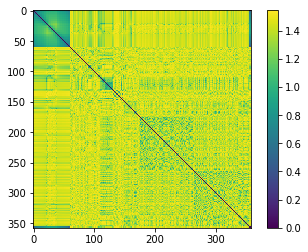

In [57]:
plt.imshow(distance_matrix[subset_idx, :][:,subset_idx])
plt.colorbar()

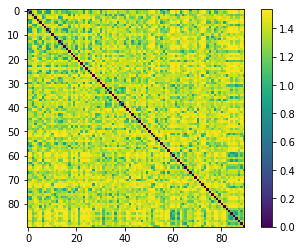

In [58]:
plt.imshow(distance_matrix[subset_idx_rec, :][:,subset_idx_rec])
plt.colorbar()